# Only works on Google Colab

In [2]:
import os
from google.colab import drive
# Google Colab with Personal Google Drive
drive.mount('/content/drive')
# Change to project folder
path = r"/content/drive/MyDrive/University of Southampton/COMP6247 Reinforcement Learning & Online Learning/RL&OL Assignment"
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dynamic Maze model

In [3]:
# My dynamic Maze
import numpy as np

class Objects:
  wall=0
  free=1
  fire=2
  goal=3
  agent=4

# color & index
color_wall = (10, 11, 12)    # 0
color_free = (224, 224, 224)  # 1
color_fire = (255, 0, 0)      # 2
color_goal = (51, 255, 51)    # 3
colors = [color_wall, color_free, color_fire, color_goal]

class DMaze:
  def __init__(self, shape, point_start, point_end):
    self.height = shape[0]
    self.width = shape[1]
    self.point_start = point_start
    self.point_end = point_end
    self.maze = np.zeros(shape, dtype=np.uint8) # stores observed map, assume all walls after init
    self._set_cell(point_end, Objects.goal)
  
  @property
  def size(self):
    return self.height * self.width
  
  # update observed maze and return the transformed local values, obs_3x3, 
  # that use the same format in my dmaze model
  def _update_maze(self, center, around):
    obs_3x3 = np.zeros(shape=[3, 3], dtype=np.uint8)
    for i in range(3):
        for j in range(3):
          # determine the type of the cell
          #found = 0
          if around[j][i][0]==0:
            # find a wall
            found = Objects.wall
          else:
            # if not a wall, it could be fire or free space.
            if around[j][i][1]==0:
              # no fire, find free space
              found = Objects.free
            else:
              # find a fire
              found = Objects.fire
          #self.maze[center[1]-1 + j][center[0]-1+i] = found
          self._set_cell((center[0]-1+i, center[1]-1 + j), found)
          obs_3x3[j][i] = found
          # reset goal point
          self._set_cell(self.point_end, Objects.goal)
    return obs_3x3
  
  # read maze from file and return transformed values
  def observe_around(self, pos):
    around = get_local_maze_information(pos[1], pos[0])
    return around, self._update_maze(pos, around)
  
  # get cell type from observed map.
  # it will be a wall if the cell never explored.
  # assume all walls outside of the maze
  def get_cell(self, pos):
    if self.is_pos_valid(pos):
      return self.maze[pos[1], pos[0]]
    # else if out of index, it's a wall
    return Objects.wall

  def _set_cell(self, pos, value):
    if self.is_pos_valid(pos):
      self.maze[pos[1]][pos[0]] = value
      # else don't update if out of range

  def draw(self, rgb_img=None):
    if rgb_img== None:
      rgb_img = np.empty([self.maze.shape[1], self.maze.shape[0], 3], dtype=np.uint8)
    for x in range(self.maze.shape[1]):
      for y in range(self.maze.shape[0]):
        rgb_img[y][x] = colors[self.maze[y][x]]
    return rgb_img

  def is_cell_onfire(self, pos):
    return self.get_cell(pos) == Objects.fire

  def is_pos_valid(self, pos):
    x, y = pos
    return x>0 and x<self.width-1 and y>0 and y<self.height-1

# Q table

In [4]:
class Qtable:
  def __init__(self, num_actions, shape_maze):
    self.num_actions=num_actions
    self.height = shape_maze[1]
    self.width = shape_maze[0]
    size_state = self.width * self.height
    # create a new table
    self.table = np.zeros(shape=(size_state, num_actions), dtype=np.float64)

  def reset(self):
    self.table = np.zeros(shape=(self.width * self.height, self.num_actions), dtype=np.float64)

  def getQ(self, x, y, action_idx):
    return self.table[self._state(x, y)][action_idx]
  
  # get a list of q value for all actions
  def getQs(self, x, y):
    return self.table[self._state(x, y)]
  
  def setQ(self, x, y, action_idx, value):
    self.table[self._state(x,y)][action_idx] = value

  def _state(self, x, y):
    return y*self.width + x


# Agent

In [5]:
# Agent

class Robot:
  actions = [
             [0, 0],    # 0 don't move
             [0, -1],   # 1 up
             [0, 1],   # 2 down
             [-1, 0],   # 3 left
             [1, 0],   # 4 right
  ]
  action_space = [0, 1, 2, 3, 4]

  def __init__(self, q_table, gamma, epsilon):
    self.q_table = q_table
    self.gamma = gamma
    self._epsilon = epsilon

  @property
  def position(self):
    return [self.x, self.y]

  def setPos(self, pos):
      self.x=pos[0]
      self.y=pos[1]
      self.path.append(pos)
  
  def reset(self):
    self.epsilon = self._epsilon
    self.path = list()

  def updateQ(self, old_posi, new_posi, action, reward, alpha):
    x = old_posi[0]
    y = old_posi[1]
    old_Q = self.q_table.getQ(x, y, action)
    if new_posi[0]==199 and new_posi[1]==199:
      self.q_table.setQ(x, y, action, 20)
    else:
      next_maxQ = np.max(self.q_table.getQs(new_posi[0], new_posi[1]))
      new_Q = old_Q + alpha * ((reward + self.gamma*next_maxQ) - old_Q)
      self.q_table.setQ(x, y, action, new_Q)
    return new_Q

  # return global position after move
  def if_act(self, action):
    move = self.actions[action]
    new_x = self.x+move[0]
    new_y = self.y+move[1]
    return (new_x, new_y)

  # select an action using greedy method
  def choose_action(self, pos, obs_3x3):
    valid_actions = Robot.find_valid_actions(obs_3x3)
    action = self.greedy_epsilon(pos, obs_3x3, valid_actions)
    return action

  def find_valid_actions(obs_3x3):
    actions = [1, 2, 3, 4]
    # up side is not free
    if obs_3x3[0][1] == Objects.wall:
      actions.remove(1)
    # down side
    if obs_3x3[2][1] == Objects.wall:
      actions.remove(2)
    # left
    if obs_3x3[1][0] == Objects.wall:
      actions.remove(3)
    # right
    if obs_3x3[1][2] == Objects.wall:
      actions.remove(4)
    return actions
        
  # states includes its position and observation
  def greedy_epsilon(self, pos, obs, valid_actions):
    # option 1: 
    # choose action by experience
    if np.random.random() < self.epsilon:
      Qs = list()
      for action in valid_actions:
        Qs.append(self.q_table.getQ(pos[0], pos[1], action))
      
      Qs_array = np.array(Qs)

      if(len(Qs_array[Qs_array == np.max(Qs_array)]) != 1):
        return  valid_actions[np.random.choice(np.arange(0,len(Qs_array[Qs_array == np.max(Qs_array)])))]

      return valid_actions[np.argmax(Qs)]
    # option 2: 
    # use a valid random action
    else:
      action_indices = np.random.choice(valid_actions)
      return action_indices

  color_agent = (51, 153, 255)
  def draw(self, rgb_img):
    # draw path
    # draw agent
    rgb_img[self.y][self.x] = Robot.color_agent


# Environment

In [6]:
# MazeEnv
class MazeEnv:
  def __init__(self, point_start, point_end, size_maze, robot):
    self.point_start = point_start
    self.point_end = point_end
    self.robot = robot
    self.size_maze = size_maze
    self.dmaze = DMaze(self.size_maze, self.point_start, self.point_end)
    # d = dx + dy (dx,dy>0)
    self.distance_max = (point_end[0]-point_start[0]) + (point_end[1]-point_start[1])

  def step(self, action):
    old_posi = self.robot.position
    new_posi = self.robot.if_act(action)
    self.robot.setPos(new_posi)
    reward = self._get_reward(old_posi, new_posi) # act -> reward
    around, new_obs = self.dmaze.observe_around(self.robot.position) # observe around 3x3
    done = self.is_win()

    self.total_rewards += reward
    return around, new_obs, reward, done

  def reset(self):
    self.total_rewards=0
    self.robot.reset()
    self.robot.setPos(self.point_start)
    self.visited = np.zeros(self.size_maze)
    around, obs = self.dmaze.observe_around(self.robot.position) # initial state
    return around, obs
  
  # return how many times the bot visited this cell
  def robot_visit(self, pos)->int:
    x, y = pos
    times = self.visited[y][x]
    self.visited[y][x] += 1
    return times

  def is_visited(self, pos):
    x, y = pos
    return self.visited[y][x] != 0

  # state function = robot position
  def get_state(self):
    return self.robot.position

  def _get_reward(self, old_pos, new_pos):
    # 1. distance reward
    ## calc manhattan distance
    distance_old = self.point_end[0]-old_pos[0] + self.point_end[1]-old_pos[1]
    distance_now = self.point_end[0]-new_pos[0] + self.point_end[1]-new_pos[1]
    ## calc rewards
    if distance_old > distance_now:
      reward = (-0.0019) * (self.point_end[0]-new_pos[0]) + (-0.0012) * (self.point_end[1]-new_pos[1]) + 3
    else:
      reward = -1
    # 2. repeated step reward
    visit_times = self.robot_visit(new_pos)
    if visit_times !=0:
      reward = -4 - 0.2 * visit_times
    return reward

  def is_win(self):
    return self.robot.x==self.point_end[0] and self.robot.y==self.point_end[1]

  # return current maze state in rgb arrays format
  def render(self):
    img = self.dmaze.draw()
    self.robot.draw(img)
    return img

# Main

## Monitor

In [7]:
import matplotlib.pyplot as plt
import pandas as pd 
import time, os

color_path = (30, 120, 200)

# Monitor class
# intent to data collection, analysis and output
class M:
  epoch = 0
  step = 0
  wins = 0
  env=None
  q_table = None
  robot = None
  rewards = list()
  q_values = list()
  steps = list()

  # out put for every # steps
  def is_output_enabled(epoch, step, done):
    return step%5000==0 or done

  # excuted at the begining of each epoch
  def on_epoch_begin(epoch):
    M.epoch = epoch
    M.rewards = list()
    M.q_values = list()
    M.step = 0

  # excuted after each step
  def on_step_end(epoch, step, pos, around, action, reward, done, q_value):
    # log values
    M.step=step
    M.rewards.append(reward)
    M.q_values.append(q_value)
    # print logs
    if M.is_output_enabled(epoch, step, done):
      if step%5000==0:
        M.draw_maze(M.env.render)
      
      print(f'agent pos: {pos}')
      print(f'agent q table: {M.q_table.getQs(pos[0], pos[1])}')
      print(f'step: {step} action: {action} reward: {reward} total rewards: {M.env.total_rewards}')
      print(f'epoch: {epoch} epsilon: {M.robot.epsilon} wins: {M.wins}')
      print(f'around: \n{around[:,:,0]}\n{around[:,:,1]}')

  # run at the end of each epoch
  def on_epoch_end(epoch, step):
    M.wins += 1
    M.steps.append(step)
    # export data
    dir = f"./wins_{epoch}/"
    M.export_files(epoch, dir)
    M.draw_path(M.env, save_dir=dir)
    M.draw_reward_step_plot(dir)
    M.draw_q_value_step_plot(dir)
    M.draw_step_epoch_plot(epoch, dir)
    

  def export_files(epoch, dir="./export/"):
    print("exporting...")
    t = time.localtime()
    current_time = time.strftime("%H:%M:%S", t)
    print(current_time)
    if not os.path.exists(dir):
      os.mkdir(dir)
    pd.DataFrame(M.env.dmaze.maze).to_csv(dir + "maze.csv")
    pd.DataFrame(M.robot.path).to_csv(dir + "robot_path.csv", mode='a')
    pd.DataFrame(M.q_table.table).to_csv(dir + "q_table.csv")
    f = open(dir+"info", "w")
    f.write(f"epoch: {epoch} steps: {M.step} total_rewards: {M.env.total_rewards}")
    f.close()

  def draw_maze(render):
    rgb_img = render()
    plt.figure(figsize=(15,15))
    plt.imshow(rgb_img, interpolation='nearest')
    plt.axis('off')
    plt.pause(0.02)
  
  def draw_path(env, save_dir=None):
    img = env.render()
    for point in env.robot.path:
      x = int(point[1])
      y = int(point[0])
      # in order to keep the fire point show on the picture
      # dont draw path on the point of fire
      if img[x][y][0] != color_fire[0] \
          or img[x][y][1] != color_fire[1] \
          or img[x][y][2] != color_fire[2]:
        img[x][y] = color_path
    plt.figure(figsize=(15,15))
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    if save_dir != None:
      plt.savefig(save_dir + 'path_plot.png', bbox_inches='tight')
    plt.show()

  def draw_reward_step_plot(dir=None):
      # reward vs. step
      plt.figure()
      plt.plot(M.rewards)
      plt.title('Reward vs. Step')
      plt.xlabel('Steps')
      plt.ylabel('Reward')
      if dir != None:
        plt.savefig(dir+'reward_step_plot.png')
      plt.show()
  
  def draw_q_value_step_plot(dir=None):
      # Q vs. step
      plt.figure()
      plt.plot(M.q_values)
      plt.title('Q-value vs. Step')
      plt.xlabel('Steps')
      plt.ylabel('Q')
      if dir != None:
        plt.savefig(dir+'q_value_step_plot.png')
      plt.show()

  def draw_step_epoch_plot(epoch, dir=None):
      # step vs. epoch
      plt.figure()
      plt.plot(np.arange(0, epoch+1), M.steps)
      plt.title('Step vs. Epoch')
      plt.xlabel('Epoch')
      plt.ylabel('Step')
      if dir != None:
        plt.savefig(dir+'step_epoch_plot.png')
      plt.show()


## run

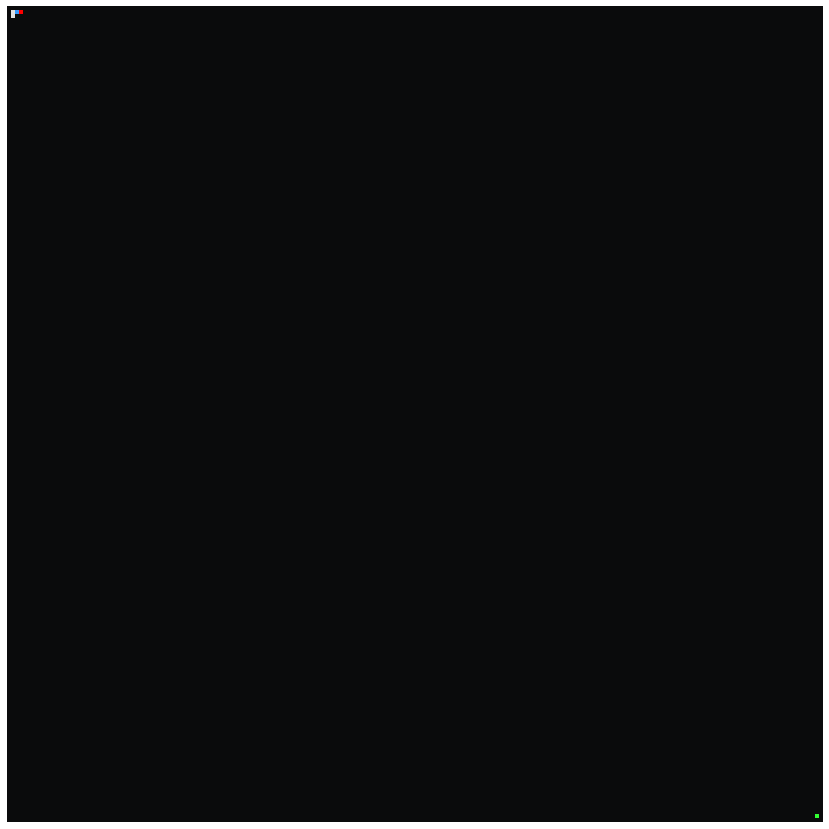

agent pos: [1, 1]
agent q table: [0.      0.      0.      0.      0.47762]
step: 0 action: 4 reward: 2.3881 total rewards: 2.3881
epoch: 0 epsilon: 0.9 wins: 0
around: 
[[0 0 0]
 [0 1 1]
 [0 1 0]]
[[0 0 0]
 [0 0 1]
 [0 0 0]]


KeyboardInterrupt: ignored

In [8]:
POINT_START = (1, 1) # start point
POINT_END = (199, 199) # goal
SIZE_MAZE = (201, 201) # maze shape

GAMMA = 0.9
ALPHA = 0.2
EPSILON = 0.9
EPSILON_INC_PER_EPOCH = 0.002

from read_maze import load_maze, get_local_maze_information

def run(num_epoch):
  # 1. init q table
  q_table = Qtable(num_actions=5, shape_maze=SIZE_MAZE)
  # collect data from q_table
  M.q_table = q_table
  # 2. init agent
  robot = Robot(q_table, GAMMA, EPSILON)
  M.robot = robot
  # 3. init env
  env = MazeEnv(POINT_START, POINT_END, SIZE_MAZE, robot)
  M.env = env
  alpha=ALPHA

  for epoch in range(num_epoch):
    # around and obs are the same, but in different shape
    load_maze()
    around, obs = env.reset() 
    done = False
    M.on_epoch_begin(epoch)
    step = 0
    q_value = 0
    # increase epsilon for each epoch
    robot.epsilon += epoch * EPSILON_INC_PER_EPOCH
    # decrease learning rate each epoch
    alpha=alpha*(1-epoch/50)
    while not done:
      # 1. get current state
      old_state = env.get_state() # state == position of robot
      # 2. select appropriate aciton
      action = robot.choose_action(old_state, obs)
      # 3. get next state
      new_state = env.get_state()
      # 4. action
      around_, obs_, reward, done = env.step(action)
      ## avoid fire
      if not env.dmaze.is_cell_onfire(new_state):
        q_value = robot.updateQ(old_state, new_state, action, reward, alpha=alpha)
      else:
        # find a fire, stay
        action = 0
      # collect&analysis datas
      M.on_step_end(epoch, step, old_state, around, action, reward, done, q_value)
      step += 1
      # 5. old state = new state
      obs = obs_
      around = around_
      # # debug
      # if step > 100:
      #   done = True
    M.on_epoch_end(epoch, step)
# run(1)
run(50)
print('done')